# !! Scroll down for XGBoost implementation

In [35]:
import os
from collections import Counter
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET
import numpy as np
from scipy import sparse

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
# these are the fifteen malware classes we're looking for
malware_classes = ["Agent", "AutoRun", "FraudLoad", "FraudPack", "Hupigon", "Krap",
           "Lipler", "Magania", "None", "Poison", "Swizzor", "Tdss",
           "VB", "Virut", "Zbot"]

# a function for writing predictions in the required format
def write_predictions(predictions, ids, outfile):
    """
    assumes len(predictions) == len(ids), and that predictions[i] is the
    index of the predicted class with the malware_classes list above for 
    the executable corresponding to ids[i].
    outfile will be overwritten
    """
    with open(outfile,"w+") as f:
        # write header
        f.write("Id,Prediction\n")
        for i, history_id in enumerate(ids):
            f.write("%s,%d\n" % (history_id, predictions[i]))

In [37]:
import pandas as pd

ids_classes = []
trees = []
for fname in os.listdir('train'):
    if fname == '.DS_Store':
        continue
    id_str, clazz = fname.split('.')[:2]
    ids_classes.append((id_str, clazz))
    tree = ET.parse(os.path.join('train', fname))
    trees.append(tree)

train_df = pd.DataFrame.from_records(ids_classes, columns=['id','class']) 

In [38]:
train_df.head()

,id,class
0,00269ea50001a6c699d0222032d45b74b2e7e8be9,None
1,00278ec420236020d6121dffe0cc20034422e7228,Lipler
2,002d5615d19c851934dc481c607b6a74a6e9e536e,VB
3,006be5Dc265600c19728c9747fb4c7bc9e8d6f106,None
4,0089453df77890cae95ce7d9130a4ef85eaea36e8,Swizzor


In [39]:
y = train_df['class'].values

In [40]:
def to_2class(classes):
    return ['None' if label == 'None' else 'Mal' for label in classes] 

In [41]:
not_calls = ['processes','all_section','thread','process']
docs = []
for tree in trees:
    calls = []
    for ele in tree.iter():
        if ele.tag not in not_calls:
            calls.append(ele.tag)   
    docs.append(calls)

In [72]:
vectorizer = TfidfVectorizer(ngram_range=(1,5))
tfidf = vectorizer.fit_transform([' '.join(doc) for doc in docs])

In [73]:
X = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())

In [44]:
lr = LogisticRegression()

In [45]:
def classify_and_score(clf, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    clf.fit(X_train, y_train)
    train_preds = clf.predict(X_train)
    print 'train accuracy: ' + str(metrics.accuracy_score(y_train, train_preds))
    test_preds = clf.predict(X_test)
    print 'validation accuracy: ' + str(metrics.accuracy_score(y_test, test_preds))
    return X_train, X_test, y_train, y_test

In [46]:
_ = classify_and_score(lr, X, y)

train accuracy: 0.821521175454
validation accuracy: 0.812176165803


In [47]:
rfc = RFC(n_estimators=50)
_ = classify_and_score(rfc, X, y)

train accuracy: 0.991789109767
validation accuracy: 0.900259067358


In [48]:
topfeats = rfc.feature_importances_.argsort()[-10:][::-1]
X.columns[topfeats]

Index([u'vm_allocate vm_protect create_thread_remote',
       u'create_thread_remote vm_allocate',
       u'open_file vm_allocate vm_protect', u'create_thread connect_socket',
       u'get_host_by_name', u'query_value create_process',
       u'create_window get_system_directory find_window',
       u'get_system_directory', u'create_mutex get_system_directory',
       u'open_file vm_allocate'],
      dtype='object')

In [49]:
bottomfeats = rfc.feature_importances_.argsort()[:10][::-1]
X.columns[bottomfeats]

Index([u'open_file get_system_time set_value',
       u'open_file get_system_time read_value',
       u'open_file get_system_time open_key',
       u'open_file get_system_time open_file',
       u'open_file get_system_time load_image',
       u'open_file get_system_time get_system_time',
       u'open_file get_system_time get_file_attributes',
       u'open_file get_system_time find_window',
       u'open_file get_system_time delete_share', u'accept_socket'],
      dtype='object')

In [50]:
print X.shape
X_trans = rfc.transform(X)
print X_trans.shape

(3086, 15336)
(3086, 1422)


//anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


In [76]:
X_trans

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.00108171,  0.00023368, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.00562801,  0.00687816, ...,  0.        ,
         0.        ,  0.        ]])

In [51]:
_ = classify_and_score(rfc, X_trans, y)

train accuracy: 0.993085566119
validation accuracy: 0.900259067358


In [52]:
_ = classify_and_score(rfc, X_trans, to_2class(y))

train accuracy: 0.994382022472
validation accuracy: 0.930051813472


In [53]:
svm = LinearSVC()
_ = classify_and_score(svm, X_trans, y)

train accuracy: 0.873379429559
validation accuracy: 0.825129533679


In [54]:
from sklearn.grid_search import GridSearchCV

In [55]:
param_grid = {'n_estimators':[50, 100, 200, 500]}
gs_rfc = GridSearchCV(rfc, param_grid)

In [56]:
gs_rfc.fit(X_trans, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [57]:
def plot_grid_scores(grid_scores, param_name, log=False):
    params =  [model.parameters[param_name] for model in grid_scores]
    scores = [model.mean_validation_score for model in grid_scores]
    plt.plot(params, scores)
    if log:
        plt.xscale('log')
    plt.xlabel(param_name)
    plt.ylabel('accuracy')
    plt.show()

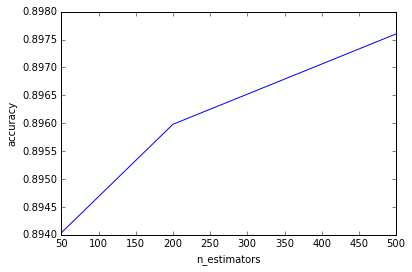

In [75]:
plot_grid_scores(gs_rfc.grid_scores_, 'n_estimators')

## XGBoost Multiclassification
### https://github.com/dmlc/xgboost/blob/master/demo/multiclass_classification/train.py

In [ ]:
malware_classes = ["Agent", "AutoRun", "FraudLoad", "FraudPack", "Hupigon", "Krap",
           "Lipler", "Magania", "None", "Poison", "Swizzor", "Tdss",
           "VB", "Virut", "Zbot"]

In [98]:
y_list = []
for clazz in y:
    i=0
    for el in malware_classes:
        if clazz == el:
            y_list.append(i)
        i+=1
        
numerical_y = np.array(y_list)

In [102]:
print y.shape
print numerical_y.shape

(3086,)
(3086,)


In [137]:
import numpy as np
import xgboost as xgb

train_X, test_X, train_Y, test_Y = train_test_split(X, numerical_y)

xg_train = xgb.DMatrix( train_X, label=train_Y)
xg_test = xgb.DMatrix(test_X, label=test_Y)
# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 6
param['silent'] = 1
#param['nthread'] = 4 #If not defined, it is set to maximum
param['num_class'] = 15
param["booster"] = "gbtree"
#param["lambda"] = 1 #default: 1
#param["alpha"] = 0 #default:0
#param["gamma"] = 0 # the larger the more conservative the model is

num_round = 5 # Given was 5 (Train error decreases with increasing rounds, maybe keep it small to avoid overfitting)
ntree=200 # Given was 6

watchlist = [ (xg_train,'train'), (xg_test, 'test') ]

#Tree
bst = xgb.train(param, xg_train, num_round, watchlist );
# get prediction
pred = bst.predict( xg_test , ntree_limit=ntree);

print ('predicting, classification error (Tree)=%f' % (sum( int(pred[i]) != test_Y[i] for i in range(len(test_Y))) / float(len(test_Y)) ))


#General Linear 
param["booster"] = "gblinear"
bst_linear = xgb.train(param, xg_train, num_round, watchlist );
# get prediction
pred_linear = bst_linear.predict( xg_test );

print ('predicting, classification error (Generalized Linear)=%f' % (sum( int(pred_linear[i]) != test_Y[i] for i in range(len(test_Y))) / float(len(test_Y)) ))




[0]	train-merror:0.072602	test-merror:0.116580
[1]	train-merror:0.060501	test-merror:0.110104
[2]	train-merror:0.050130	test-merror:0.102332
[3]	train-merror:0.045376	test-merror:0.090674
[4]	train-merror:0.039758	test-merror:0.091969
[0]	train-merror:0.027226	test-merror:0.101036
[1]	train-merror:0.058341	test-merror:0.147668
[2]	train-merror:0.143042	test-merror:0.196891
[3]	train-merror:0.732498	test-merror:0.787565
[4]	train-merror:0.369490	test-merror:0.362694


predicting, classification error (Tree)=0.091969
predicting, classification error (Generalized Linear)=0.362694
